In [ ]:
# SPDX-License-Identifier: MIT

# Lab 3 Graph Neural Networks

Copyright (C) 2025 Jacob Farnsworth.

Created for HT 2025 Programmering för tekniska tillämpningar, NTI Gymnasiet Karlstad

## Write your name here


## Review of Graphs

Recall that a *graph* is a type of data structure which consists of nodes and edges. Additionally, every node and edge can have some data associated to it. Graphs are often used to represent networks of data connected by different kinds of relationships.

There are two main kinds of graphs:

A *directed graph* has edges with associated direction. An edge in a directed graph points from one node to another.

Examples of directed graphs:

*   Social networks, with people as nodes, and friend or follow relationships as edges.
*   Computer networks, with devices as nodes, and connections as edges.
*   Webpage links, with webpages as nodes, and links as edges. This kind of graph is frequently used in web search engines.
*   Dependency networks, with tasks as nodes, and dependencies as edges. This kind of graph is frequently used in software build systems to determine which order to build submodules in a large project.

An *undirected graph* has edges which connect nodes, but without any concept of forward or backward. An undirected edge simply links two nodes together.

Examples of undirected graphs:

*   Traffic maps, with towns and cities as nodes, and highways as edges.
*   Molecules, with atoms as nodes, and chemical bonds as edges.
*   Scientific collaboration, with people as nodes, and edges between people if they have authored a paper together.



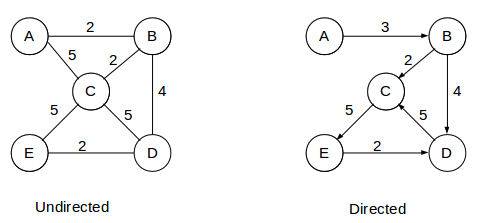

### Question

Name each type of graph:

1.   A graph with OOP classes (Java or C++) as nodes, and inheritance relationships as edges. For example, if there is a class Animal, and a class Cat which inherits from Animal, then there is an arrow from Cat to Animal.
2.   A social network graph with people as nodes, but with follow relationships as edges, instead of friend relationships.
3.   A peer-to-peer filesharing network, such as BitTorrent. In these types of networks, any client can both upload and download from any other client in the network.



Graph Neural Networks (GNNs) are a type of neural network which operate on graphs. Common tasks for GNNs include classifying graphs, generating graphs based on input data, or predicting missing nodes, edges, or data in a graph.

In this lab, we will experiment with graph neural networks and apply them to *molecule data*, showing the potential of neural networks to solve problems involving more advanced data structures.

## Install Packages

In this lab, we will be using the machine learning framework Pytorch along with several useful libraries:

*   **torch_geometric** contains layers and models we'll be using to build GNNs. This library also contains supporting code to help us load and work with graph data.
*   **rdkit** contains a collection of code to help with chemistry data such as molecules.
*   **py3Dmol** can help us visualize molecules in 3D.
*   **scikit-learn** contains many useful helper functions; we will mainly use it to help with preprocessing.
*   **torch_scatter** contains some useful tensor math operations which don't exist in the base Pytorch.



In [ ]:
!pip install torch torch_geometric rdkit py3Dmol scikit-learn torch_scatter

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached py3dmol-2.5.0-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.

## Import Libraries

Now that we have all the packages installed, we can start to import needed libraries.

In [ ]:
import os
import random
from typing import List, Sequence, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.metrics import average_precision_score, roc_auc_score
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.nn.models import GIN
from torch_geometric.utils import smiles

import py3Dmol

## SMILES And Molecule Visualization

Before we start working on our GNN, let's take an aside to understand the data we'll be working with.

SMILES is a format commonly used to represent molecules as text strings. A SMILES string contains all the needed information about a molecule, including its atoms, bonds, and structure.

Below are some SMILES strings for various molecules.

In [ ]:
# SMILES string for water
molecule1_smiles = "O"

# SMILES string for ethanol
molecule2_smiles = "OCC"

# SMILES string for aspirin (common pain reliever, fever reducer)
molecule3_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"

# SMILES string for caffeine
molecule4_smiles = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"

# SMILES string for 2,4-dinitrophenol (DNP)
# (Once used as a weight loss drug, now banned due to toxicity.)
molecule5_smiles = "O=[N+]([O-])c1cc(ccc1O)[N+]([O-])=O"

Below is a function that uses the rdkit library to draw a 2D diagram of a model based on a SMILES string. The diagram shows atoms and bonds as well as the structure of the molecule.

This type of diagram is very common in organic chemistry.

In [ ]:
def visualize_molecule_2d(smiles_str: str):
    mol = Chem.MolFromSmiles(smiles_str)

    img = Draw.MolToImage(mol)
    display(img)

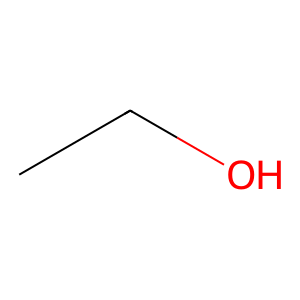

In [ ]:
# Draw a 2D diagram for a molecule (ethanol)
visualize_molecule_2d(molecule2_smiles)

With a 2D diagram, it can be hard to visualize the structure of more complex molecules. Also, the 2D diagram does not show hydrogen atoms.

The function below uses the py3Dmol library to create an interactive 3D diagram of a molecule given the SMILES string. This diagram helps us see the structure of the molecule more clearly, and it also shows hydrogen atoms.

In [ ]:
def visualize_molecule_3d(smiles_str: str):
    mol = Chem.MolFromSmiles(smiles_str)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)

    block = Chem.MolToMolBlock(mol)

    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(block, "mol")
    viewer.setStyle({'stick': {}, 'sphere': {'scale': 0.3}})
    viewer.setBackgroundColor("white")
    viewer.zoomTo()
    viewer.show()

In [ ]:
# Draw a 3D diagram for a molecule (ethanol)
visualize_molecule_3d(molecule2_smiles)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Questions

Using the SMILES codes and the functions above for drawing diagrams and models of molecules, answer the following questions:

1.   How many oxygen, nitrogen and hydrogen atoms are there in one DNP molecule?
2.   How many double bonds are there in one DNP molecule?
3.   How many rings are there in one DNP molecule?



## Acquire Device

Here we instruct Pytorch to use the GPU if available.

In [ ]:
torch.manual_seed(0)
random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

The following snippet loads the dataset and prepares the train/test split.

In our first experiment, we will use the ClinTox dataset which is included with torch_geometric. This dataset consists of SMILES strings for various medicines, and whether they were approved by the US Food and Drug Administration, or failed clinical trials due to toxicity.

The data consists of rows of the form:
```smiles,FDA_APPROVED,CT_TOX```

In [ ]:
dataset = MoleculeNet(root=os.path.expanduser('~/molecule-datasets/'), name='ClinTox')

try:
    num_tasks = dataset.num_tasks
except AttributeError:
    num_tasks = dataset[0].y.size(-1)

lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths.append(len(dataset) - sum(lengths))
train_set, valid_set, test_set = torch.utils.data.random_split(
    dataset, lengths, generator=torch.Generator().manual_seed(0)
)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=1024)
test_loader = DataLoader(test_set, batch_size=1024)

Extracting /root/molecule-datasets/clintox/raw/clintox.csv.gz
Processing...
/usr/local/lib/python3.11/dist-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule '[NH4][Pt]([NH4])(Cl)Cl' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/usr/local/lib/python3.11/dist-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'c1ccc(cc1)n2c(=O)c(c(=O)n2c3ccccc3)CCS(=O)c4ccccc4' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/usr/local/lib/python3.11/dist-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'Cc1cc2c(cc1C)N3C=N2[Co+]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)[O-])C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)O' since it resulted in zero atoms
  warnings.warn(f"Skipping 

Let's take a look at some of the data points from the training set. The following code randomly extracts one molecule along with FDA status and toxicity from the dataset.

In [ ]:
random_index = random.randint(0, len(train_set) - 1)
random_tuple = train_set[random_index]
smiles_str, fda_approval, toxic = random_tuple.smiles, random_tuple.y[0][0], random_tuple.y[0][1]

print(f"Sample molecule:\n{smiles_str}")
print(f"FDA Approved: {fda_approval}")
print(f"Toxic: {toxic:.1f}")

Sample molecule:
CC(=O)N(CCCCCNC(=O)CCC(=O)N(CCCCCNC(=O)CCC(=O)N(CCCCC[NH3+])O)O)O
FDA Approved: 1.0
Toxic: 0.0


In [ ]:
# Visualize the sample molecule from the training data
visualize_molecule_3d(smiles_str)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Questions

1.   Why is it important to use a *train-test split* when training a deep learning model?
2.   What is the index of the FDA_APPROVED entry in the ClinTox dataset? What about the CT_TOX entry?



## Model Definition

At this point, we define our model class. We will use a type of model called a Graph Isomorphism Network (GIN) which is a very powerful type of model for deep learning on graphs.

The idea of Graph Isomorphism Network is based on theory from a paper by Xu et. al. (https://arxiv.org/abs/1810.00826)

Our model class is very general. It does not force a certain input size or number of hidden layers. Rather, the sizes and number of layers are given in the constructor, which then builds the model according to the desired specs.

In [ ]:
class GIN(nn.Module):
    """Multi-layer GIN with concat-hidden readout and dropout."""

    def __init__(self, input_dim: int, hidden_dims: Sequence[int], num_tasks: int, dropout: float = 0.5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.dropout = dropout

        prev_dim = input_dim
        for dim in hidden_dims:
            mlp = nn.Sequential(
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Linear(dim, dim),
            )
            self.convs.append(GINConv(mlp))
            self.bns.append(nn.BatchNorm1d(dim))
            prev_dim = dim

        self.readout_dim = sum(hidden_dims)
        self.lin = nn.Linear(self.readout_dim, num_tasks)

    def forward(self, x, edge_index, batch):
        hidden: List[torch.Tensor] = []
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            hidden.append(x)
        pooled = [global_add_pool(h, batch) for h in hidden]
        out = torch.cat(pooled, dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin(out)

## Training and Evaluation

Here we define a function `train_epoch` which trains the model for one epoch. We follow the standard training procedure for neural networks: reset the gradient, get predictions per batch, compute the new loss and gradient, apply the optimizer, and finally, update statistics. This process is repeated for all batches in the current epoch.

We also define the function `evaluate` which computes metrics for the model. For this task we will use AUROC and AUPRC.

**AUROC** stands for Area Under the Receiver Operating Characteristic Curve. This measure indicates how good the model is at identifying positives above negatives at different thresholds.

AUROC is useful when the dataset is balanced or slightly to moderately imbalanced. Higher (closer to 1) is better.

AUROC also has a nice interpretation in terms of probability; it can be seen as the "probability that a uniformly drawn positive has a higher score than a uniformly drawn negative".

**AUPRC** stands for Area Under the Precision-Recall Curve. This measure is more heavily affected by the model's ability to make positive identifications even when positive entries in the dataset are very rare. Hence, this measure is more useful when the dataset is imbalanced (very few positive entries). Higher (closer to 1) is better.

The reason we use these metrics (especially AUPRC) instead of simple accuracy in this lab is because medical datasets often contain imbalances, and simple accuracy can be misleading for such datasets.

For example, say that a dataset has an output class (0=Healthy, 1=Disease) and the training data consists of 943 healthy patients and 57 sick patients. In this case, if we simply always guess "healthy" 100% of the time, then we can easily achieve 94.3% accuracy.

Seems pretty good, right? Wrong: in reality, the model mostly failed at what we actually want to use it for, namely, to identify positive cases even when they're very rare. Therefore, it would be better to measure AUROC and AUPRC in this situation.

What is considered a "good" AUPRC value depends on the dataset. For imbalanced datasets, an AUPRC value which seems small could be considered "good".

For the example above (943 healthy, 57 sick), the sick patients comprise about 57/1000*100 = 5.7% of the dataset. In this case, a baseline AUPRC value would be 57/1000 = 0.057. This is approximately the AUPRC that would be expected from a model which simply guesses randomly. Hence, in this example, any AUPRC value above 0.057 would be better than baseline.

Comparing the AUPRC value of a model allows us to get a rough idea of how well the model performs:

3x baseline: decent

4x baseline: good

6x baseline or higher: excellent

Hence, in this example, a model with an AUPRC value of 0.2, which is about 3.5 times higher than baseline, would be considered decent or somewhat good.

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, n = 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(pred, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        n += batch.num_graphs
    return total_loss / n


def evaluate(model, loader, device):
    """Evaluate AUROC & AUPRC across all tasks, ignoring NaNs."""
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            y_pred_list.append(model(batch.x, batch.edge_index, batch.batch).cpu())
            y_true_list.append(batch.y.cpu())

    # Convert collections
    y_true = np.concatenate([t.numpy() for t in y_true_list], axis=0)
    y_pred = torch.sigmoid(torch.cat(y_pred_list, dim=0)).numpy()

    # Metrics
    aurocs, auprcs = [], []
    for i in range(y_true.shape[1]):
        mask = ~np.isnan(y_true[:, i])
        if mask.sum() == 0:
            continue
        try:
            aurocs.append(roc_auc_score(y_true[mask, i], y_pred[mask, i]))
            auprcs.append(average_precision_score(y_true[mask, i], y_pred[mask, i]))
        except ValueError:
            pass
    return aurocs, auprcs, dict(
        auroc=float(np.mean(aurocs)) if aurocs else float('nan'),
        auprc=float(np.mean(auprcs)) if auprcs else float('nan'),
    )

### Questions

1. Find out how many drugs in ClinTox have `CT_TOX=1` and how many have `CT_TOX=0`.
2. Based on this information, is it appropriate to use AUROC and AUPRC here, or would it be better to use another metric, such as simple accuracy or MSE? Explain why or why not.
3. Using your answer to the first part, compute a baseline AUPRC value.

## Creating & Training The Model

In [ ]:
model = GIN(input_dim=dataset.num_features,
            hidden_dims=[32, 32],
            num_tasks=num_tasks,
            dropout=0.4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    loss = train_epoch(model, train_loader, optimizer, criterion, device)
    if epoch % 10 == 0:
        aurocs, auprcs, avgs = evaluate(model, valid_loader, device)
        print(f"Epoch {epoch:3d} – loss: {loss:.4f} – AUROC: {avgs['auroc']:.4f} – AUPRC: {avgs['auprc']:.4f}")

Epoch  10 – loss: 0.5764 – AUROC: 0.6405 – AUPRC: 0.5307
Epoch  20 – loss: 0.4419 – AUROC: 0.7033 – AUPRC: 0.5700
Epoch  30 – loss: 0.3454 – AUROC: 0.6643 – AUPRC: 0.5432
Epoch  40 – loss: 0.3300 – AUROC: 0.7021 – AUPRC: 0.5532
Epoch  50 – loss: 0.2934 – AUROC: 0.7174 – AUPRC: 0.5617
Epoch  60 – loss: 0.2911 – AUROC: 0.7343 – AUPRC: 0.5637
Epoch  70 – loss: 0.2848 – AUROC: 0.7146 – AUPRC: 0.5442
Epoch  80 – loss: 0.2575 – AUROC: 0.6469 – AUPRC: 0.5317
Epoch  90 – loss: 0.2590 – AUROC: 0.7186 – AUPRC: 0.5767
Epoch 100 – loss: 0.2439 – AUROC: 0.8366 – AUPRC: 0.5819


## Evaluation

The following code prints AUROC and AUPRC for the trained model.



In [ ]:
aurocs, auprcs, avgs = evaluate(model, valid_loader, device)
print(f"Average - auroc: {avgs['auroc']:.4f}, auprc: {avgs['auprc']:.4f}")
print("Per-task:")
print(f"FDA_APPROVED - auroc: {aurocs[0]:.4f}, auprc: {auprcs[0]:.4f}")
print(f"CT_TOX - auroc: {aurocs[1]:.4f}, auprc: {auprcs[1]:.4f}")

Average - auroc: 0.8366, auprc: 0.5819
Per-task:
FDA_APPROVED - auroc: 0.8527, auprc: 0.9894
CT_TOX - auroc: 0.8205, auprc: 0.1744


### Questions

1.   Compare the AUPRC value for the CT_TOX task to the baseline value you computed earlier.
2.   Based on your comparison, how is the performance of the model? Is the model's performance decent, good, or excellent?



## Improvements

Let's see if we can make some improvements to the model and improve the performance. Your task is to conduct a series of experiments where you adjust the hyperparameters as well as the model's structure and see if you can achieve better results.

For this lab, aim to achieve a CT_TOX-AUPRC value of at least 0.5.

**REMEMBER: Document your results thoroughly and clearly.** For each run, record the combination of hyperparameters and the final AUROC and AUPRC values.

Some of the values you can adjust:

*   Number of hidden dims (try 3, 4 instead of 2)
*   Hidden dimension size (try 128, 256, 512 instead of 32)
*   Learning rate (try 1e-4 instead of 1e-3)
*   Dropout (try 0.0, 0.2, or 0.5 instead of 0.4)



### Questions



1.   What was your best model? (Number of hidden dims, hidden dim size, learning rate, dropout, and any other values you changed)
2.   Copy and paste your best model's evaluation, including AUROC and AUPRC values. Include the average values and the values by task.
3.   How does your best model compare to the baseline from earlier?



### YOUR CODE

Paste your code for your best-trained model below.

## Further Tests



The following code defines a function `predict_smiles` which uses the model to predict FDA approval and toxicity for an input drug, given as a SMILES string.

We can use this function to test the model on any drug.

In [ ]:
def predict_smiles(smiles_str: str, model: nn.Module, device: torch.device) -> Tuple[float, float]:
    """Return (FDA_prob, Toxic_prob) for a given SMILES string."""
    mol = Chem.MolFromSmiles(smiles_str)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles_str}")

    data_obj = smiles.from_smiles(smiles_str)

    loader = DataLoader([data_obj], batch_size=1)
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader)).to(device)
        logits = model(batch.x, batch.edge_index, batch.batch)
        probs = torch.sigmoid(logits).cpu().view(-1)

    fda_prob, tox_prob = probs[0].item(), probs[1].item()
    return fda_prob, tox_prob

Below are several SMILES strings for various medicines you can try with the model. Some of the medicines are well-known and widely used, and others were experimental prototypes which failed clinical trials for toxicity reasons.

In [ ]:
# 2,4-dinitrophenol
# Once used as a weight loss drug.
# Eventually banned due to dangerous toxicity.
# "O=[N+]([O-])c1cc(ccc1O)[N+]([O-])=O"

# Terfenadine
# Prototype antihistamine.
# Was suspended from clinical trials for causing cardiac arrhythmia.
# "CC(C)(C)C1=CC=C(C=C1)C(CCCN2CCC(CC2)C(C3=CC=CC=C3)(C4=CC=CC=C4)O)O"

# Fexofenadine (Allegra)
# Antihistamine.
# Safe and approved.
# "CC(C)(C1=CC=C(C=C1)C(CCCN2CCC(CC2)C(C3=CC=CC=C3)(C4=CC=CC=C4)O)O)C(=O)O"

# Atorvastatin
# Treatment for high cholesterol.
# Safe and approved.
# "CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4"

# Fialuridine
# Prototype treatment for Hepatitis B.
# Was suspended from clinical trials for causing liver failure and death.
# "C1=C(C(=O)NC(=O)N1[C@H]2[C@H]([C@@H]([C@H](O2)CO)O)F)I"

# BIA 10-2474
# Prototype antidepressant.
# Was withdrawn for mysteriously causing brain damage and death in clinical trials.
# "CN(C1CCCCC1)C(=O)N2C=C(N=C2)C3=C[N+](=CC=C3)[O-]"


In [ ]:
fda_prob, tox_prob = predict_smiles("CC(C)(C1=CC=C(C=C1)C(CCCN2CCC(CC2)C(C3=CC=CC=C3)(C4=CC=CC=C4)O)O)C(=O)O", model, device)
print(f"FDA Approved Prob: {fda_prob:.2f} | Toxic Prob: {tox_prob:.2f}")

FDA Approved Prob: 0.10 | Toxic Prob: 0.81


### Questions

Using the `predict_smiles` function, test your best trained model on some of the approved and unapproved medicines defined above.

1.   How does the model perform on these medicines? Record and display your results clearly, preferably in some kind of table. Generally, does the model seem accurate?
2.   Compare these results to the AUROC and AUPRC values from the evaluation earlier. Does the model seem better or worse compared to the evaluation? If there was any difference in results, try to explain some possible reasons why.



## (VG) Compare GNN Types

In this lab we used GIN layers in our model, which is a powerful type of graph convolutional layer. However, there are many different types of GNN layers.

See documentation of torch_geometric for all the supported layer types: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers

Your task in this part is to compare other types of GNN layers against the GIN layers we used before. Choose **at least 2** other graph convolutional layer types and build and train models using them. You can use the code from before and modify it to use the new layers.

As always, document your results thoroughly. Record AUROC and AUPRC for the models you train, and save the code from your best test runs.

### Questions

* How did the other layer types perform? Did you find a layer type that performed better than GIN?
* Which layers performed worse than GIN?
* Compare the layers not just in accuracy, but in other aspects as well. Training time? Size, number of parameters?

### YOUR CODE


# AI Deklaration

Användning av Al-verktyg är tillåtet i begränsad utsträckning. Du får inte klistra in uppgifter eller delar av uppgifter, men du får använda AI för att förtydliga nya ord och begrepp eller ge exempel.

Här på slutet ska du ange allmänt vilka AI-verktyg som använts, hur du använt dem, och hur användbara dessa verktyg är. Om du inte använt AI-stöd så skriv bara att "AI-verktyg har ej använts".



### STUDENTSVAR (AI-användning):